<a href="https://colab.research.google.com/github/rssiuiuc/CropSight/blob/main/CropSight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CropSight: Object-Based Crop Type Ground Truth Retrieval

This notebook demonstrates the usage of the CropSight framework for retrieving object-based crop type ground truth data using **Google Street View** and **PlanetScope** satellite imagery. In this example, we will focus on Illinois (IL) and consider only corn and soybean due to their dominance in the region.

The implementation of CropSight requires GPU for efficient processing. It is encouraged to use Google Colab to run this notebook and activate the GPU. To do this, connect to a T4 GPU by changing the runtime type in the top right corner.


## Step 1: Clone the Repository

To get started, we need to clone the CropSight repository from Hugging Face. This repository contains all the necessary parameters for the UncertainFusionNet and SAM models.


In [1]:
!git clone https://huggingface.co/lyfranki/CropSight/

Cloning into 'CropSight'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 16 (delta 3), reused 0 (delta 0), pack-reused 4 (from 1)
Unpacking objects: 100% (16/16), 5.55 KiB | 1.39 MiB/s, done.
Filtering content: 100% (3/3), 1.20 GiB | 26.23 MiB/s, done.


## Step 2: Cropland Field-View Imagery Collection

In this step, we collect and process panorama Google Street View (GSV) images. If you wish to collect your own images, you can refer to the [Google Street View website](https://www.google.com/streetview/) for detailed information on how to use the API.

For this example, the panorama GSV image is provided included in the CropSight repository.


### Display the GSV panaroma

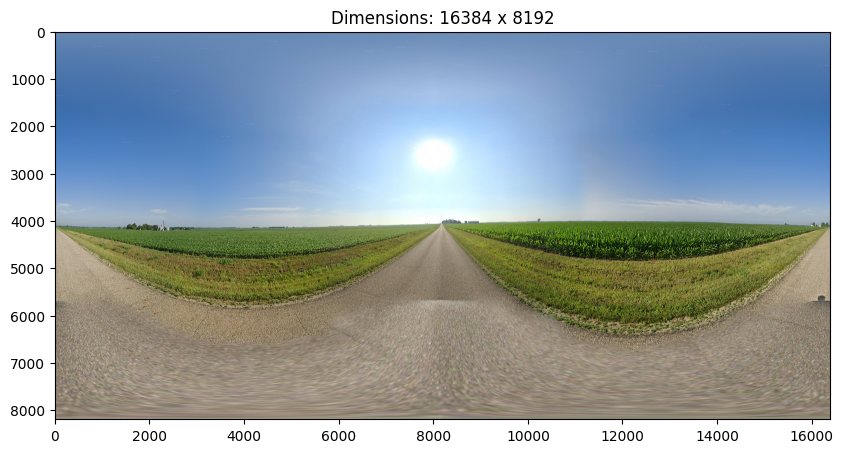

In [3]:
from PIL import Image
import matplotlib.pyplot as plt
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Load the image
image_path = './CropSight/6Ciwoz1IMxaB8BscGsPlNQ_40.339872_-89.269831_2023-07_90.jpg'
image = Image.open(image_path)


# Get image dimensions
width, height = image.size

# Display the image with larger size
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('on')  # Show the axis

# Show image dimensions as title
plt.title(f"Dimensions: {width} x {height}")
plt.show()


### Extract GSV roadsides images

In [4]:
import pandas as pd
import urllib.request, os
import urllib.parse
import numpy as np
import imageio as im
!pip install geopandas
import geopandas as gpd
from math import pi
import numpy as np
import re
from datetime import datetime
import requests
import time
import shutil
import itertools
from PIL import Image
from io import BytesIO
import os
import numpy as np
!pip install skimage
from skimage import io
import requests
import json

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [5]:
class NFOV():
    def __init__(self, height=2000, width=4000):
        self.FOV = [0.45, 0.45]
        self.PI = pi
        self.PI_2 = pi * 0.5
        self.PI2 = pi * 2.0
        self.height = height
        self.width = width
        self.screen_points = self._get_screen_img()

    def _get_coord_rad(self, isCenterPt, center_point=None):
        return (center_point * 2 - 1) * np.array([self.PI, self.PI_2]) \
            if isCenterPt \
            else \
            (self.screen_points * 2 - 1) * np.array([self.PI, self.PI_2]) * (
                np.ones(self.screen_points.shape) * self.FOV)

    def _get_screen_img(self):
        xx, yy = np.meshgrid(np.linspace(0, 1, self.width), np.linspace(0, 1, self.height))
        return np.array([xx.ravel(), yy.ravel()]).T

    def _calcSphericaltoGnomonic(self, convertedScreenCoord):
        x = convertedScreenCoord.T[0]
        y = convertedScreenCoord.T[1]

        rou = np.sqrt(x ** 2 + y ** 2)
        c = np.arctan(rou)
        sin_c = np.sin(c)
        cos_c = np.cos(c)

        lat = np.arcsin(cos_c * np.sin(self.cp[1]) + (y * sin_c * np.cos(self.cp[1])) / rou)
        lon = self.cp[0] + np.arctan2(x * sin_c, rou * np.cos(self.cp[1]) * cos_c - y * np.sin(self.cp[1]) * sin_c)

        lat = (lat / self.PI_2 + 1.) * 0.5
        lon = (lon / self.PI + 1.) * 0.5

        return np.array([lon, lat]).T

    def _bilinear_interpolation(self, screen_coord):
        uf = np.mod(screen_coord.T[0],1) * self.frame_width  # long - width
        vf = np.mod(screen_coord.T[1],1) * self.frame_height  # lat - height

        x0 = np.floor(uf).astype(int)  # coord of pixel to bottom left
        y0 = np.floor(vf).astype(int)
        x2 = np.add(x0, np.ones(uf.shape).astype(int))  # coords of pixel to top right
        y2 = np.add(y0, np.ones(vf.shape).astype(int))

        base_y0 = np.multiply(y0, self.frame_width)
        base_y2 = np.multiply(y2, self.frame_width)

        A_idx = np.add(base_y0, x0)
        B_idx = np.add(base_y2, x0)
        C_idx = np.add(base_y0, x2)
        D_idx = np.add(base_y2, x2)

        flat_img = np.reshape(self.frame, [-1, self.frame_channel])

        A = np.take(flat_img, A_idx, axis=0)
        B = np.take(flat_img, B_idx, axis=0)
        C = np.take(flat_img, C_idx, axis=0)
        D = np.take(flat_img, D_idx, axis=0)

        wa = np.multiply(x2 - uf, y2 - vf)
        wb = np.multiply(x2 - uf, vf - y0)
        wc = np.multiply(uf - x0, y2 - vf)
        wd = np.multiply(uf - x0, vf - y0)

        # interpolate
        AA = np.multiply(A, np.array([wa, wa, wa]).T)
        BB = np.multiply(B, np.array([wb, wb, wb]).T)
        CC = np.multiply(C, np.array([wc, wc, wc]).T)
        DD = np.multiply(D, np.array([wd, wd, wd]).T)
        nfov = np.reshape(np.round(AA + BB + CC + DD).astype(np.uint8), [self.height, self.width, 3])
        align_x = int(self.width/2-self.height/2)
        align_y = int(self.width/2+self.height/2)
        nfov = nfov[:,align_x:align_y,:]
        # import matplotlib.pyplot as plt
        # im.imwrite('D:/phd/Meeting/10-19-GSV/image_writing25.jpg', nfov)
        # plt.imshow(nfov)
        # plt.show()
        return nfov

    def toNFOV(self, frame, center_point):
        self.frame = frame
        self.frame_height = frame.shape[0]
        self.frame_width = frame.shape[1]
        self.frame_channel = frame.shape[2]

        self.cp = self._get_coord_rad(center_point=center_point, isCenterPt=True)
        convertedScreenCoord = self._get_coord_rad(isCenterPt=False)
        spericalCoord = self._calcSphericaltoGnomonic(convertedScreenCoord)
        return self._bilinear_interpolation(spericalCoord)

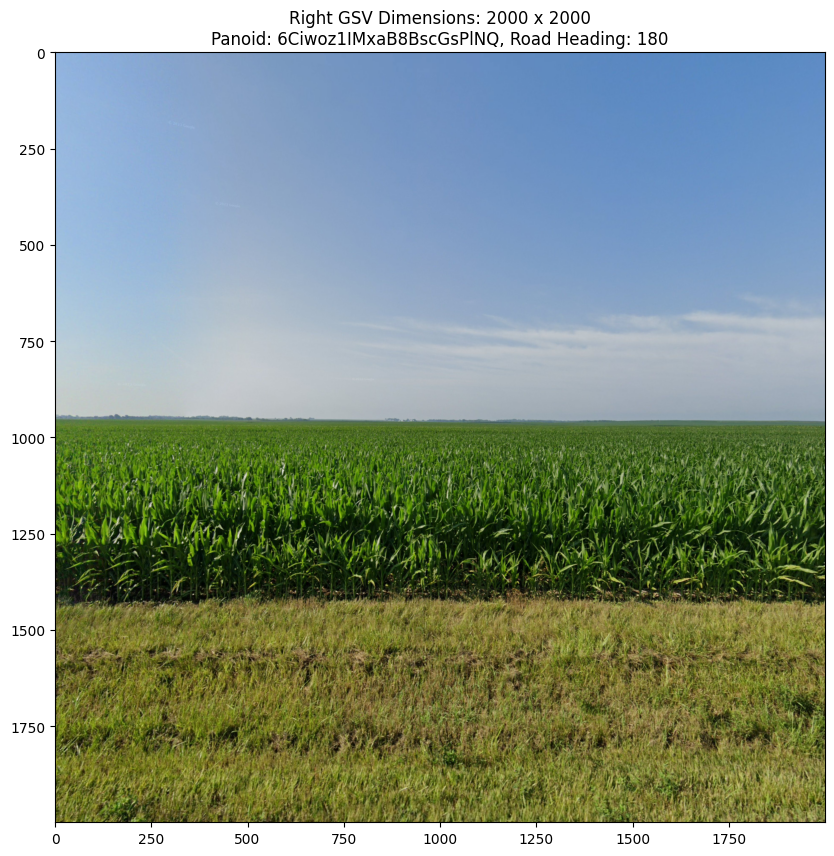

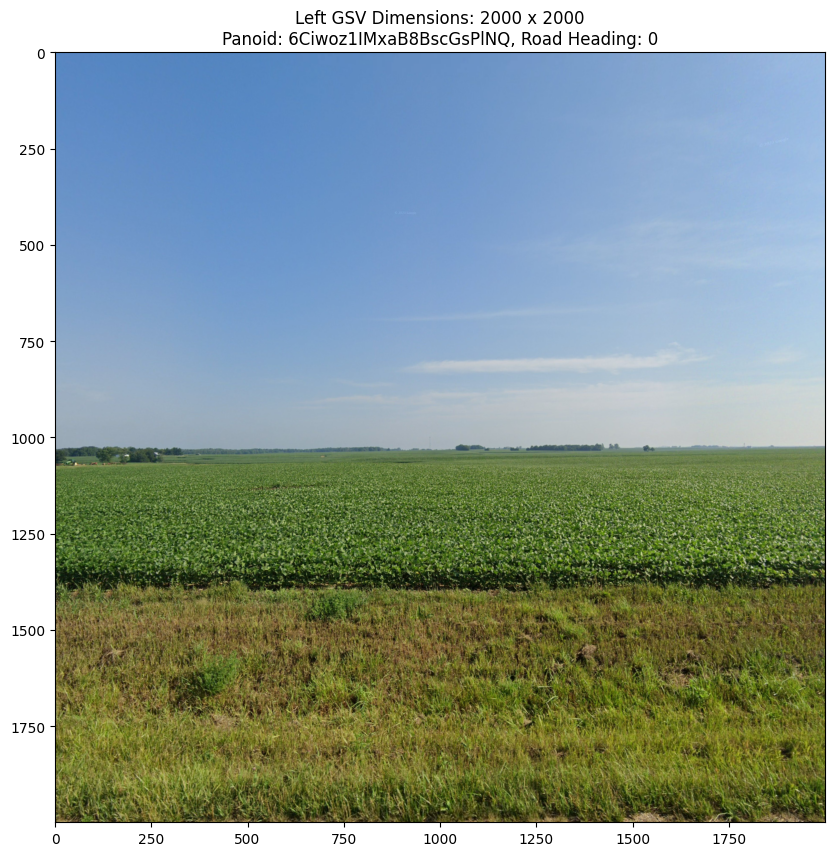

In [6]:
import imageio as im

# Extract variables from the image filename
filename_parts = os.path.basename(image_path).split('_')
panoid = filename_parts[0]
Lat = float(filename_parts[1])
Long = float(filename_parts[2])
year, month = map(int, filename_parts[3].split('-'))
heading = int(filename_parts[4].split('.')[0])


panorama_path = image_path

img = im.imread(panorama_path)
road_heading_right = (heading + 90 ) % 360
road_heading_left = (heading - 90 ) % 360

# extracte two road sides images
## right GSV when driving
nfov = NFOV()
center_point = np.array([.75, .5])  # camera center point (valid range [0,1])
image_right = nfov.toNFOV(img, center_point)
GSV_road_path_right = panoid + "_" +str(Lat) + "_" + str(Long)  + "_" +str(year)  + "_" +str(month) + "_" + str(road_heading_right) +".jpg"
if not os.path.exists(GSV_road_path_right):
  im.imwrite(GSV_road_path_right, image_right)


# Display the right GSV image with dimensions
plt.figure(figsize=(10, 10))
plt.imshow(image_right)
plt.axis('on')
right_height, right_width, _ = image_right.shape
plt.title(f"Right GSV Dimensions: {right_width} x {right_height}\nPanoid: {panoid}, Road Heading: {road_heading_right}")
plt.show()

## left GSV when driving
nfov = NFOV()
center_point = np.array([.25, .5])  # camera center point (valid range [0,1])
image_left = nfov.toNFOV(img, center_point)
GSV_road_path_left = panoid + "_" +str(Lat) + "_" + str(Long) + "_" +str(year)  + "_" +str(month) + "_" + str(road_heading_left) +".jpg"
if not os.path.exists(GSV_road_path_left):
  im.imwrite(GSV_road_path_left, image_left)

# Display the left GSV image with dimensions
plt.figure(figsize=(10, 10))
plt.imshow(image_left)
plt.axis('on')
left_height, left_width, _ = image_left.shape
plt.title(f"Left GSV Dimensions: {left_width} x {left_height}\nPanoid: {panoid}, Road Heading: {road_heading_left}")
plt.show()

### Enhance cropland field-view images

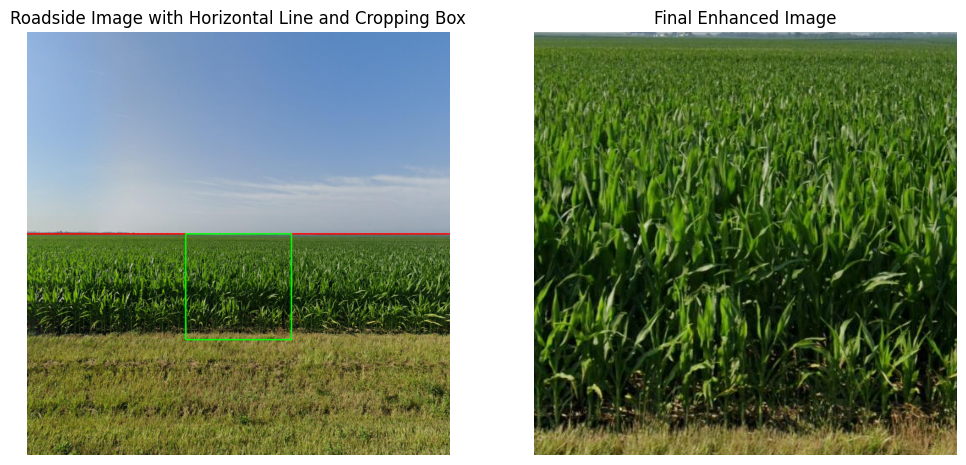

Final output image saved at: 6Ciwoz1IMxaB8BscGsPlNQ_40.339872_-89.269831_2023_7_180_final_output.jpg


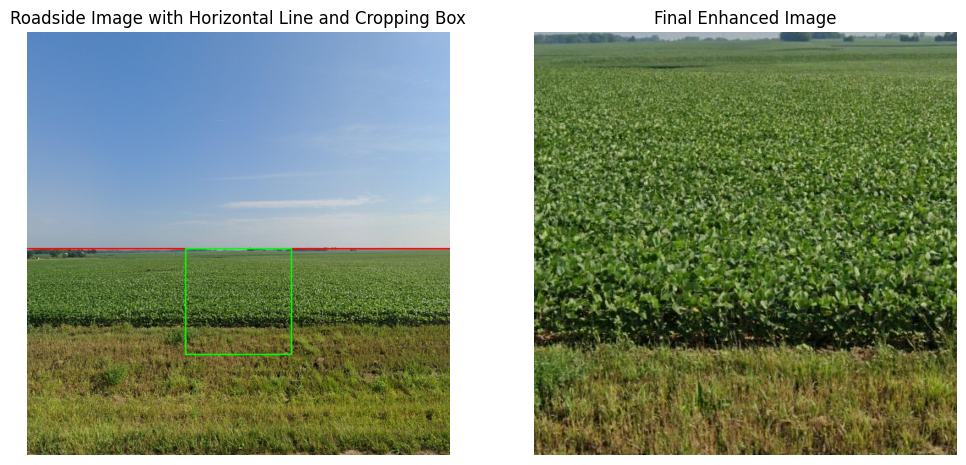

Final output image saved at: 6Ciwoz1IMxaB8BscGsPlNQ_40.339872_-89.269831_2023_7_0_final_output.jpg


In [9]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def automatically_enhance_image(image_path):
    """
    Automatically enhance cropland field-view images by applying median blur,
    edge detection, and cropping based on edge density.
    """
    # Load the image
    image = cv2.imread(image_path)

    # Apply median blur
    image_blur = cv2.medianBlur(image, 5)

    # Convert to gray scale
    gray = cv2.cvtColor(image_blur, cv2.COLOR_BGR2GRAY)

    # Apply Canny edge detection
    edged = cv2.Canny(image_blur, 10, 150)

    # Create a DataFrame from the edge-detected image
    df = pd.DataFrame(edged)

    # Count the non-zero values in each row
    count_255 = df.ne(0).sum(1)

    # Find the horizontal line to crop
    crop_horizontal_line = 0
    i = 0

    while crop_horizontal_line < 750:
        crop_horizontal_line = count_255[count_255 > 150].index[i]
        i += 1

    # Draw the horizontal line and the box on the original image
    image_with_line = image.copy()
    cv2.line(image_with_line, (0, crop_horizontal_line), (image.shape[1], crop_horizontal_line), (0, 0, 255), 5)
    cv2.rectangle(image_with_line, (750, crop_horizontal_line), (1250, crop_horizontal_line + 500), (0, 255, 0), 5)

    # Crop the image
    crop_image = image[crop_horizontal_line:crop_horizontal_line + 500, 750:1250, :]

    # Save the final output image with the line and box
    base_filename = os.path.splitext(os.path.basename(image_path))[0]
    final_output_path = f"{base_filename}_final_output.jpg"

    cv2.imwrite(final_output_path, crop_image)

    # Display the final output image with the line and box, and the cropped image side by side
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image_with_line, cv2.COLOR_BGR2RGB))
    plt.title('Roadside Image with Horizontal Line and Cropping Box')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(crop_image, cv2.COLOR_BGR2RGB))
    plt.title('Final Enhanced Image')
    plt.axis('off')

    plt.show()

    print(f"Final output image saved at: {final_output_path}")
    return final_output_path

# Image paths
right_image_path = GSV_road_path_right  # Replace with your right image path
left_image_path = GSV_road_path_left  # Replace with your left image path

# Automatically enhance and get output paths for the right image
final_right_image_path = automatically_enhance_image(right_image_path)

# Automatically enhance and get output paths for the left image
final_left_image_path = automatically_enhance_image(left_image_path)


## Step 3: Crop Type Retrieval

In this step, we will retrieve crop type labels and prediction uncertainty using UncertainFusionNet, a deep learning model specifically designed for classifying crop species in street view images.

UncertainFusionNet combines features extracted from two state-of-the-art image classification architectures: Vision Transformer and Residual Neural Network (ResNet). By fusing these features, the model enhances its classification capabilities. Additionally, UncertainFusionNet incorporates Monte Carlo (MC) Dropout in the classification layer to provide uncertainty estimates for each image classification, alongside the probability of each class.

### Key Features of UncertainFusionNet:
- **Dual Architecture Fusion**: Combines Vision Transformer and ResNet for robust feature extraction.
- **MC Dropout**: Provides uncertainty estimates for each classification, offering more reliable predictions.
- **High Accuracy**: Designed to classify crop types with high precision.

This model is essential for accurately identifying crop types from street view images while also understanding the confidence level of each prediction.


### Loading UncertainFusionNet
When loading the packages, you may encounter warnings. If this happens, there is no need to restart the runtime. Simply rerun the cell again to proceed.


In [11]:
!pip install split-folders
!pip install -U transformers datasets
from __future__ import print_function, division
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch import nn
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt
from transformers import ViTFeatureExtractor, ViTForImageClassification
from torchvision.models.feature_extraction import create_feature_extractor


In [12]:
# Define labels
labels = ['corns', 'others', 'soybeans']

# Define and prepare ResNet model
model_rn = models.resnet50(pretrained=True)
num_ftrs = model_rn.fc.in_features
model_rn.fc = nn.Linear(num_ftrs, 768)

# Define and prepare ViT model
model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor(size=500, image_mean=[0.485, 0.456, 0.406], image_std=[0.229, 0.224, 0.225])
model_vit = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)
model_vit.classifier = nn.Identity()

# Define ensemble model

class EnsembleModel(nn.Module):
    def __init__(self, modelA, modelB):
        super().__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.avepool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self._fc1 = nn.Linear(768 * 2 + 512, 1024)
        self._fc2 = nn.Linear(1024,512)
        self.dropout3 = nn.Dropout(0.3)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.3)
        self.classifier = nn.Linear(512, 3)

    def forward(self, x):
        x1 = self.modelA(x,interpolate_pos_encoding = True).logits
        x2 = self.modelB(x)
        intermediate_features = create_feature_extractor(self.modelB, return_nodes=['layer2'])(x)
        x3 = self.avepool(intermediate_features['layer2']).reshape(-1,512)
        x = torch.cat((x1, x2,x3), dim=1)
        x = self.dropout1(x)
        x = self._fc1(x)
        x = self.relu1(x)
        x = self.dropout2(x)
        x = self._fc2(x)
        x = self.relu2(x)
        x = self.dropout3(x)
        out = self.classifier(x)
        return out


# Initialize ensemble model
ensemble_model = EnsembleModel(model_vit, model_rn)


# Define custom loss function
class CrossEntropyPELoss(nn.Module):
    def __init__(self):
        super(CrossEntropyPELoss, self).__init__()

    def forward(self, input, target):
        prob = F.softmax(input, dim=1)
        log_prob = torch.log(prob)
        MeanPE = -torch.sum(prob * log_prob) / prob.size(dim=0)
        CrossEntropyLoss = nn.CrossEntropyLoss()
        loss = CrossEntropyLoss(input, target) + MeanPE
        return loss

# Load model checkpoint
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_dir = './CropSight/UncertainFusionNet(IL).pth'
checkpoint = torch.load(model_dir, map_location=device)
ensemble_model.load_state_dict(checkpoint['model_state_dict'])
ensemble_model.to(device)
ensemble_model.eval()


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 77.3MB/s]


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EnsembleModel(
  (modelA): ViTForImageClassification(
    (vit): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): ViTPatchEmbeddings(
          (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0-11): 12 x ViTLayer(
            (attention): ViTSdpaAttention(
              (attention): ViTSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
     

### Crop type classification

In [14]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize(500),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
left_image_path = final_left_image_path  # Replace with actual path
left_img = Image.open(left_image_path)
left_img_tensor = transform(left_img).unsqueeze(0).to(device)

right_image_path = final_right_image_path  # Replace with actual path
right_img = Image.open(right_image_path)
right_img_tensor = transform(right_img).unsqueeze(0).to(device)

# Function to run Monte Carlo Dropout
def monte_carlo_dropout(img_tensor, model, running_time):
    multi_list = []
    for iter in range(running_time):
        for m in model.modules():
            if m.__class__.__name__.startswith('Dropout'):
                m.train()
        result = model(img_tensor)
        probs = F.softmax(result, dim=-1)
        multi_list.append(probs.tolist()[0])
    return multi_list


# Function to calculate uncertainty
def calculate_uncertainty(multi_list, labels):
    my_array = np.array(multi_list)
    mean_probs = np.mean(my_array, axis=0)
    var_probs = np.var(my_array, axis=0)

    max_value = max(mean_probs)
    max_index = mean_probs.tolist().index(max_value)

    log_prob = np.log(mean_probs)
    entropy = -np.sum(mean_probs * log_prob)
    model_uncertainty = np.sum(var_probs) / len(mean_probs)

    print(f"Uncertainty for the estimation: {model_uncertainty} (variance),  {entropy} (entropy), Mean Prob: {mean_probs}, Prediction: {labels[max_index]}")

    return mean_probs, labels[max_index], entropy, model_uncertainty

# Monte Carlo dropout for uncertainty estimation
running_time = 100
multi_list = []

multi_list_left = monte_carlo_dropout(left_img_tensor, ensemble_model, running_time)
multi_list_right = monte_carlo_dropout(right_img_tensor, ensemble_model, running_time)


print("Monte Carlo Dropout results for left image:")
left_mean_value, left_label, left_entropy, left_uncertainty = calculate_uncertainty(multi_list_left, labels)

print("Monte Carlo Dropout results for right image:")
right_mean_value, right_label, right_entropy, right_uncertainty = calculate_uncertainty(multi_list_right, labels)

Monte Carlo Dropout results for left image:
Uncertainty for the estimation: 8.093901899675384e-07 (variance),  0.01010086469483282 (entropy), Mean Prob: [3.77644839e-05 1.26101519e-03 9.98701224e-01], Prediction: soybeans
Monte Carlo Dropout results for right image:
Uncertainty for the estimation: 4.1605400264115517e-07 (variance),  0.0041845141311141094 (entropy), Mean Prob: [9.99550944e-01 3.14609810e-04 1.34444889e-04], Prediction: corns


## Step 4: Cropland Boundary Delineation

In this step, we employ the fine-tuned Segmentation Anything Model (SAM) to delineate the cropland boundaries associated with the crop type images.

### Key Features of SAM:
- **Satellite Imagery**: Utilizes satellite images as the primary input to capture extensive spatial details.
- **Geotagged Field-View Images**: Uses coordinates derived from geotagged field-view images as point prompts to enhance accuracy.
- **Optimized for CropSight**: The SAM model is specifically fine-tuned to extract precise cropland boundaries corresponding to each field-view image.

SAM is an optimally tailored solution for accurately extracting cropland boundaries, ensuring that the boundaries correspond correctly to the GSV images.


### Corresponding satellite image preparation

In the original design, we used **PlanetScope** imagery for training and input data. Here, we provide an alternative method using **Sentinel-2** imagery. Please note that performance may be slightly degraded due to the relatively lower spatial resolution of Sentinel-2 images compared to PlanetScope.


In [15]:
!pip install pystac_client
!pip install odc-stac
!pip install rasterio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.9/182.9 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.1/150.1 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 81.9 MB/s eta 0:00:00


In [16]:
import numpy as np
from shapely.geometry import Polygon, mapping
from osgeo import gdal

from pystac_client import Client
from odc.stac import load
import odc.geo

import xarray as xr
import numpy as np
import tifffile as tiff
from PIL import Image
import rasterio
from pyproj import Proj, transform
from rasterio.windows import Window
import math
import pyproj
def move_location(lat, lon, direction, distance):
    # Convert direction to radians
    direction_rad = math.radians(direction)

    # Convert distance to degrees (approximately)
    distance_deg = distance / 111319.9  # 1 degree = 111319.9 meters at equator

    # Calculate new latitude and longitude
    new_lat = lat + (distance_deg * math.cos(direction_rad))
    new_lon = lon + (distance_deg * math.sin(direction_rad))

    return new_lat, new_lon

def convert_bounds(bbox, invert_y=False):
    """
    Helper method for changing bounding box representation to leaflet notation

    ``(lon1, lat1, lon2, lat2) -> ((lat1, lon1), (lat2, lon2))``
    """
    x1, y1, x2, y2 = bbox
    if invert_y:
        y1, y2 = y2, y1
    return ((y1, x1), (y2, x2))

def with_nullvalue(red_values,threshold):

    # Flatten the array to simplify the counting
    flattened_values = red_values.flatten()

    # Count the number of pixels with value 0
    zero_pixel_count = np.sum(flattened_values == 0)

    # Calculate the total number of pixels
    total_pixel_count = flattened_values.size

    # Calculate the percentage of pixels with value 0
    zero_pixel_percentage = (zero_pixel_count / total_pixel_count) * 100

    # Check if the percentage of zero pixels is more than threshold%
    if zero_pixel_percentage > threshold:
        return True
    else:
        return False

def normalize_to_uint8(image):
    p2, p98 = np.percentile(image, (2, 98))
    return np.clip((image - p2) / (p98 - p2) * 255, 0, 255).astype(np.uint8)


def s2_download(latitude,longitude,time,s2_tif_path):
    # Provided longitude and latitude
    # latitude, longitude = ( -23.22253203529611, -51.022276615283225)  # Center point of a query

      # use publically available stac link such as
      client = Client.open("https://earth-search.aws.element84.com/v1")

      # ID of the collection
      collection = "sentinel-2-l2a"

      km2deg = 1.0 / 111

      r = 6 * km2deg
      bbox = (longitude - r, latitude - r, longitude + r, latitude + r)

      client = Client.open("https://earth-search.aws.element84.com/v1/")
      # date_YYMM="2023-05"
      date_YYMM= time
      search = client.search(
          collections=[collection], datetime=date_YYMM, bbox=bbox
      )

      #load the data in xarray format
      data = load(search.items() ,bbox=bbox, chunks={})
      # data = load(search.items() ,bbox=bbox,groupby="solar_day", chunks={})

      all_red = data.red.values
      target_item = -1
      target_item_eo = 100
      all_dates = data['time'].values
      all_dates_formatted = np.datetime_as_string(all_dates, unit='D')


      # loop through each item
      for item in search.items_as_dicts():

        search_datetime = item['properties']['s2:datatake_id'][5:13]
        # Convert to datetime
        date = pd.to_datetime(search_datetime, format='%Y%m%d')

        # Format the date as 'YYYY-MM-DD'
        formatted_date = date.strftime('%Y-%m-%d')

        if item['properties']['eo:cloud_cover']<target_item_eo:
          index = np.where(all_dates_formatted == formatted_date)[0][0]
          red_one_image = all_red[index,:,:]
          if with_nullvalue(red_one_image,20) == False:
            target_item = index
            target_item_eo =item['properties']['eo:cloud_cover']

      red = data.red[target_item,:,:]
      green = data.green[target_item,:,:]
      blue = data.blue[target_item,:,:]
      rgb = xr.concat([red, green,blue], dim='bands')
      odc.geo.xr.write_cog(rgb,fname=s2_tif_path,  overwrite=True)


def clip_image(tif_path,output_jpg_filename,output_tif_filename):

    # tif_path = 'image.tiff'
    with rasterio.open(tif_path) as src:
        # Get the dimensions of the input GeoTIFF
        height, width = src.height, src.width

        # Define the window to clip the input GeoTIFF
        win_xsize, win_ysize = 512, 512
        win_xstart = (width - win_xsize) // 2
        win_ystart = (height - win_ysize) // 2
        window = Window(win_xstart, win_ystart, win_xsize, win_ysize)

        # Read the data in the window for all bands
        data = src.read(window=window)

        # Get the coordinates of the window center
        center_x = win_xstart + win_xsize // 2
        center_y = win_ystart + win_ysize // 2
        center_coords = src.xy(center_y, center_x)

        # Convert the center coordinates to latitude and longitude
        utm_crs = src.crs.to_string()
        target_crs = 'EPSG:4326'  # EPSG code for WGS84, the most common coordinate system for latitude and longitude
        transformer = pyproj.Transformer.from_crs(utm_crs, target_crs, always_xy=True)
        lon, lat = transformer.transform(center_coords[0], center_coords[1])

        # Create the output GeoTIFF filename using the latitude and longitude
        # output_filename = f"/content/drive/MyDrive/Crop Classification/Agoro Field Boundary Detector/polygons/composite_{lat}_{lon}.tif"
        # output_tif_filename = f"composite_{latitude}_{longitude}.tif"

        # Create a new profile for the output GeoTIFF
        profile = src.profile
        profile.update({
            'height': win_ysize,
            'width': win_xsize,
            'transform': rasterio.windows.transform(window, src.transform)
        })

        # Write the clipped data to the output GeoTIFF
        with rasterio.open(output_tif_filename, 'w', **profile) as dst:
            dst.write(data)

        # output_jpg_filename = f"composite_{latitude}_{longitude}.jpg"
        # # Save the first three bands as a JPEG image
        data = src.read(window=window, indexes=(1, 2, 3))
        data = normalize_to_uint8(data)
        image = Image.fromarray(data.transpose(1, 2, 0)[:,:,:3])  # Transpose dimensions and select first three bands
        image.save(output_jpg_filename)
    os.remove(tif_path)




In [17]:
import re

filename = left_image_path
final_label =left_label
final_entropy =left_entropy
final_variance =left_uncertainty

# Extracting data from the filename using regular expressions
match = re.match(r"^[^_]+_([0-9\.-]+)_([0-9\.-]+)_([0-9]+)_([0-9]+)_([0-9]+)_final_output\.jpg$", filename)

if match:
    lat = float(match.group(1))
    lon = float(match.group(2))
    year = int(match.group(3))
    month = int(match.group(4))
    heading = int(match.group(5))

    print(f"Latitude: {lat}")
    print(f"Longitude: {lon}")
    print(f"Year: {year}")
    print(f"Month: {month}")
    print(f"Heading: {heading}")
else:
    print("Filename format is incorrect")


Latitude: 40.339872
Longitude: -89.269831
Year: 2023
Month: 7
Heading: 0


In [18]:
import pandas as pd
import os

# Format the date as 'YYYY-MM'
date = f'{year}-0{month}'

# Calculate new latitude and longitude based on the original location, heading, and distance
new_lat, new_lon = move_location(lat, lon, float(heading), 50)

# Define the file paths for the Sentinel-2 TIFF image and the output filenames
s2_tif_path = f'image_{new_lat}_{new_lon}.tiff'
output_tif_filename = f'{new_lat}_{new_lon}_{heading}_{date}.tif'
output_jpg_filename = f'{new_lat}_{new_lon}_{heading}_{date}.jpg'

# Download the Sentinel-2 image for the new location and date if the JPEG file does not already exist
# Uncomment the next line to check for existing files
# if not os.path.exists(output_jpg_filename):
s2_download(new_lat, new_lon, date, s2_tif_path)

# Clip the downloaded Sentinel-2 image and save it as both a JPEG and a TIFF file
clip_image(s2_tif_path, output_jpg_filename, output_tif_filename)


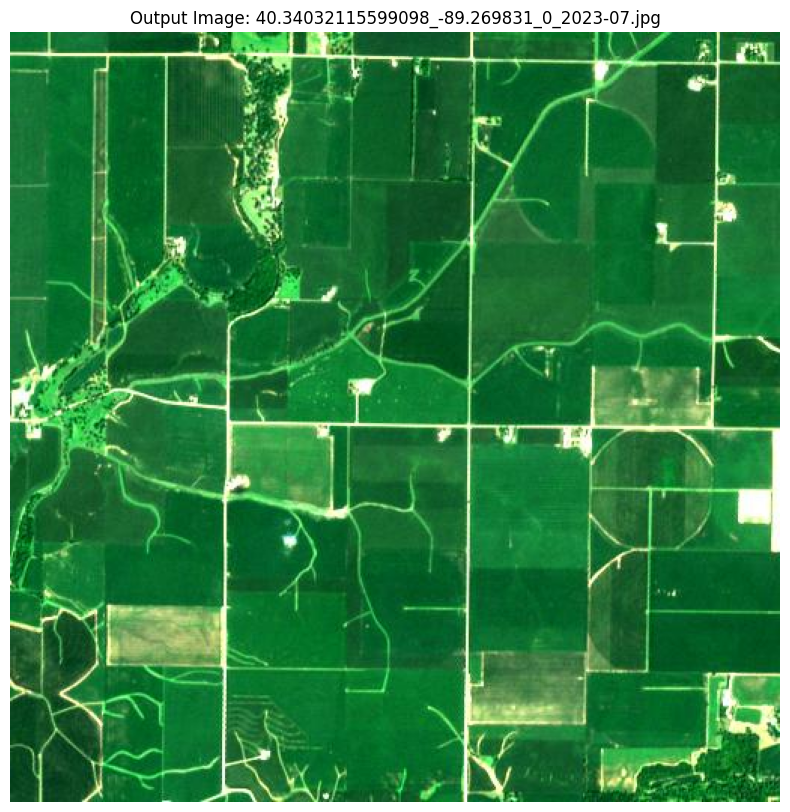

In [43]:
import matplotlib.pyplot as plt
import cv2

# Function to display the output image
def display_output_image(filename):
    # Read the image
    image = cv2.imread(filename)
    # Convert the image from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Display the image using matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.title(f"Output Image: {filename}")
    plt.axis('off')
    plt.show()

display_output_image(output_jpg_filename)


### SAM loading

In [19]:
!pip install segment_anything

In [20]:
import numpy as np
import os
import cv2
from segment_anything import sam_model_registry
from segment_anything import SamPredictor
import numpy as np
from skimage import measure #
import fiona
from shapely.geometry import Polygon,Point, mapping
from osgeo import gdal
import json
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=320):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

sam = sam_model_registry['vit_b'](checkpoint='./CropSight/SAM(IL).pth')
predictor = SamPredictor(sam)

### Boundary delineation

In [34]:
import os
import cv2
import numpy as np
from shapely.geometry import Polygon, mapping
import fiona
from skimage import measure
from osgeo import gdal

# Define the folder path for saving shapefiles
shp_folder_path = './GroundTruth/'

# Create the folder if it doesn't exist
if not os.path.exists(shp_folder_path):
    os.makedirs(shp_folder_path)

# Define the output shapefile path based on the output JPG filename
output_shp = shp_folder_path + output_jpg_filename[:-3] + 'shp'

# Check if the shapefile already exists
if not os.path.exists(output_shp):
    print(output_jpg_filename)

    # Read and process the image
    image = cv2.imread(output_jpg_filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Set the image in the predictor (assuming predictor is defined elsewhere)
    predictor.set_image(image)

    # Define the image dimensions and the central point
    width, height = 512, 512
    central_point = (width // 2, height // 2)

    # Define the input point and label for the predictor
    input_point = np.array([central_point])
    input_label = np.array([1])

    # Predict the mask and scores using the predictor
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=False,
        # multimask_output=True,  # Uncomment for multiple masks
    )

    # Select the highest score mask
    score = scores[0]
    mask = masks[0]

    # Find contours in the mask
    contours = measure.find_contours(mask, 0.5, fully_connected='high')

    # Create a list to store the contour coordinates
    contour_list = []

    # Define the target point (center of the image)
    target_point = np.array([width // 2, height // 2])  # y, x

    # Function to compute the area of a contour
    def contour_area(contour):
        x = contour[:, 1]
        y = contour[:, 0]
        return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))

    # Compute the area for each contour
    areas = [contour_area(contour) for contour in contours]

    # Function to check if a point is inside a contour
    def point_in_contour(point, contour):
        x, y = point[1], point[0]
        n = len(contour)
        inside = False
        p1x, p1y = contour[0]
        for i in range(1, n + 1):
            p2x, p2y = contour[i % n]
            if y > min(p1y, p2y):
                if y <= max(p1y, p2y):
                    if x <= max(p1x, p2x):
                        if p1y != p2y:
                            xinters = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                        if p1x == p2x or x <= xinters:
                            inside = not inside
            p1x, p1y = p2x, p2y
        return inside

    # Filter contours that contain the target point and compute their areas
    valid_contours = [contour for contour in contours if point_in_contour(target_point, contour)]

    if valid_contours:
        # Select the largest valid contour
        areas = [contour_area(contour) for contour in valid_contours]
        largest_contour = valid_contours[np.argmax(areas)]
    else:
        # Select the largest contour by size if no valid contours are found
        largest_contour = max(contours, key=lambda x: x.size)

    # Open the GeoTIFF dataset and get geotransform and projection
    geotiff_dataset = gdal.Open(output_tif_filename)
    geotransform = geotiff_dataset.GetGeoTransform()
    projection = geotiff_dataset.GetProjection()

    # Proceed if a contour covering the point is found
    if largest_contour is not None:
        # Create a georeferenced polygon from the contour
        polygon = Polygon([(geotransform[0] + x * geotransform[1], geotransform[3] + y * geotransform[5]) for y, x in largest_contour])

        # Define the schema for the shapefile
        schema = {
            'geometry': 'Polygon',
            'properties': {'label': 'str', 'entropy': 'float', 'variance': 'float'}
        }

        # Create and save the shapefile with the polygon and additional properties
        with fiona.open(output_shp, 'w', 'ESRI Shapefile', schema, crs=projection) as output:
            feature = {
                'geometry': mapping(polygon),
                'properties': {
                    'label': final_label,
                    'entropy': final_entropy,
                    'variance': final_variance
                }
            }
            output.write(feature)
    else:
        print('No polygon covers the point.')


40.34032115599098_-89.269831_0_2023-07.jpg


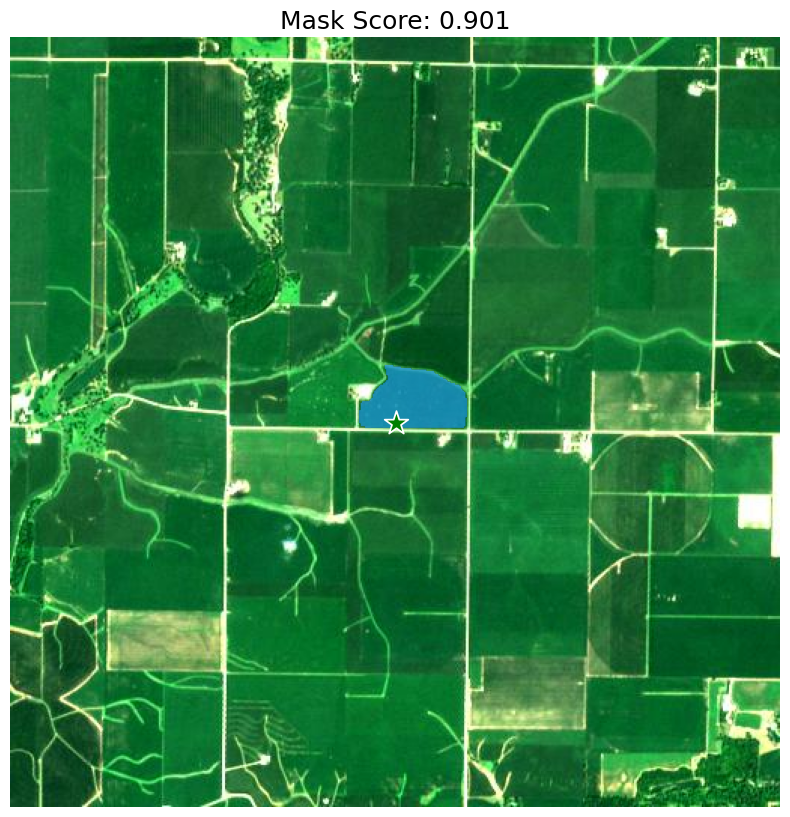

In [23]:
# Iterate over each mask and its corresponding score
for m, (mask, score) in enumerate(zip(masks, scores)):
    # Create a new figure for each mask
    plt.figure(figsize=(10, 10))

    # Display the original image
    plt.imshow(image)

    # Overlay the mask on the image
    show_mask(mask, plt.gca())

    # Display the input points on the image
    show_points(input_point, input_label, plt.gca())

    # Set the title of the plot with the mask score
    plt.title(f"Mask Score: {score:.3f}", fontsize=18)

    # Remove the axis for better visualization
    plt.axis('off')

    # Show the plot
    plt.show()


## Step 5: Showing the Object-Based Crop Type Ground Truth on the Map

In [42]:
import folium
import geopandas as gpd
from shapely.geometry import mapping
from folium.features import GeoJson, GeoJsonTooltip

# Load the shapefile using GeoPandas
gdf = gpd.read_file(output_shp)
# Transform the CRS to WGS84 (EPSG:4326)
gdf = gdf.to_crs(epsg=4326)

# Calculate the center of the map based on the shapefile's geometry
centroid = gdf.geometry.centroid.iloc[0]
center_lat = centroid.y
center_lon = centroid.x

# Create a folium map centered on the shapefile's centroid
m = folium.Map(location=[center_lat, center_lon], zoom_start=14)

# Function to get unique labels and assign colors
def get_label_colors(gdf):
    labels = gdf['label'].unique()
    colormap = folium.LinearColormap(colors=['green', 'yellow', 'red', 'purple', 'orange'], index=range(len(labels)), vmin=0, vmax=len(labels)-1)
    return {label: colormap(i) for i, label in enumerate(labels)}, colormap

# Get label colors
label_colors, colormap = get_label_colors(gdf)

# Add the GeoDataFrame to the folium map with labels
folium.GeoJson(
    gdf,
    style_function=lambda feature: {
        'fillColor': label_colors[feature['properties']['label']],
        'color': 'black',
        'weight': 2,
        'fillOpacity': 0.5,
    },
    tooltip=GeoJsonTooltip(
        fields=['label'],
        aliases=['Label: '],
        localize=True
    ),
    name="geojson"
).add_to(m)

# Add the colormap as a legend to the map
colormap.caption = 'Crop Labels'
colormap.add_to(m)

# Add a layer control panel to the map
folium.LayerControl().add_to(m)

# Display the map
m
